In [1]:
import pandas as pd

trip_data_file = "data/trip_data_4.csv"
trip_fare_file = "data/trip_fare_4.csv"

trips = pd.read_csv(trip_data_file, nrows=10000)
fares = pd.read_csv(trip_fare_file, nrows=10000)

Merge the Trip and Fare data together 

In [2]:
full_tripdata = pd.merge(left=trips,right=fares, how='left', left_on=['medallion',' hack_license',' vendor_id'], right_on=['medallion',' hack_license',' vendor_id'])
full_tripdata.columns
full_tripdata.head(2)

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime_x,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,dropoff_longitude,dropoff_latitude,pickup_datetime_y,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,91F6EB84975BBC867E32CB113C7C2CD5,AD8751110E6292079EB10EB9481FE1A6,CMT,1,N,2013-04-04 18:47:45,2013-04-04 19:00:25,1,759,2.5,...,-73.976273,40.785648,2013-04-04 18:47:45,CRD,11.0,1.0,0.5,2.5,0.0,15.0
1,EC34CD1B3797DFAFF3FE099BA87B6656,8FE6A4AEDF89B6B4E19D2377FD3FB7D7,CMT,1,N,2013-04-05 07:08:34,2013-04-05 07:17:34,1,540,1.6,...,0.000000,0.000000,2013-04-05 07:08:34,CRD,8.5,0.0,0.5,1.8,0.0,10.8


# What is the distribution of number of passengers per trip?

In [3]:
passengers = pd.crosstab(index=full_tripdata[" passenger_count"].astype("category"),columns="Frequency Probability",normalize='columns')
print passengers
passengers.plot.bar()

col_0             Frequency Probability
 passenger_count                       
1                              0.611356
2                              0.126411
3                              0.045247
4                              0.022303
5                              0.114679
6                              0.080003


# b. What is the distribution of payment_type?

col_0          Frequency Probability
 payment_type                       
CRD                         0.561704
CSH                         0.437695
UNK                         0.000601


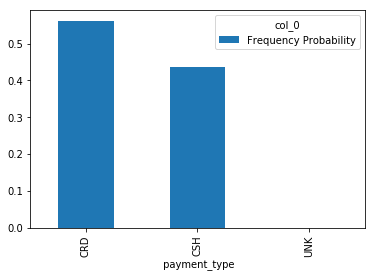

In [4]:
payment_types = pd.crosstab(index=full_tripdata[" payment_type"].astype("category"),columns="Frequency Probability",normalize='columns')
print payment_types
payment_types.plot.bar() 

# c. What is the distribution of fare amount?

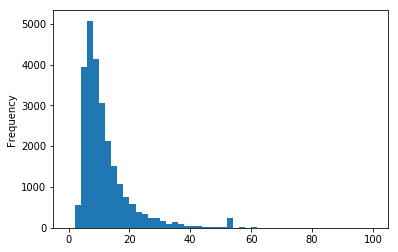

In [37]:
fare_amount = full_tripdata.iloc[:,16]
fare_amount.plot.hist(bins=50,range=(0,100))

# d. What is the distribution of tip amount?

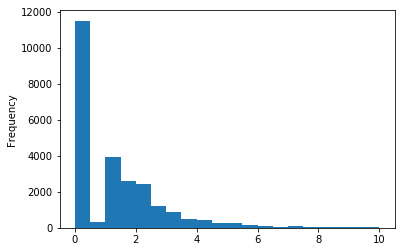

In [6]:
tips_amount = full_tripdata.iloc[:,19]
tips_amount.plot.hist(bins=20,range=(0,10))


count    24974.000000
mean         0.111290
std          0.132445
min          0.000000
25%          0.000000
50%          0.103448
75%          0.212121
max          4.800000
dtype: float64

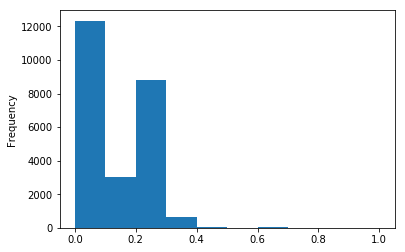

In [7]:
generosity = tips_amount /fare_amount 
generosity.plot.hist(bins=10,range=(0,1))
generosity.describe()

# e. What is the distribution of total amount?

count    24974.000000
mean        14.113623
std         10.054137
min          3.500000
25%          8.300000
50%         11.300000
75%         16.100000
max        180.000000
Name:  total_amount, dtype: float64

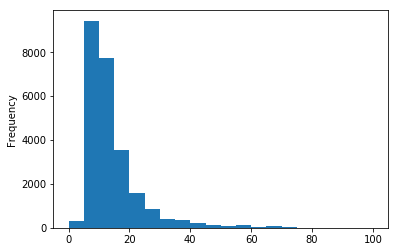

In [36]:
total_amounts = full_tripdata.iloc[:,21]
total_amounts.plot.hist(bins=20,range=(0,100))
total_amounts.describe()

# What are top 5 busiest hours of the day?

In [9]:
pickupTime = pd.DataFrame(full_tripdata.iloc[:,5])
pickupTime[" pickup_datetime_x"] = pd.to_datetime(pickupTime[" pickup_datetime_x"])
pickupTime.index = pickupTime[" pickup_datetime_x"]


frequency = pickupTime.groupby(pickupTime.index.hour).count()

frequency.sort_values(by=[" pickup_datetime_x"],ascending=False).head(5).index



Int64Index([21, 22, 20, 18, 1], dtype='int64', name=u' pickup_datetime_x')

# What are the top 10 busiest locations of the city?

In [8]:
#join the pickup and dropoff locations together
pickupLoc = pd.DataFrame(full_tripdata.iloc[:,10:12])
pickupLoc = pickupLoc.rename(columns={' pickup_longitude':'longtitude', ' pickup_latitude':'latitude'})
dropoffLoc = pd.DataFrame(full_tripdata.iloc[:,12:14],columns=["longtitude","latitude"])
dropoffLoc = pickupLoc.rename(columns={' dropoff_longitude':'longtitude', ' dropoff_latitude':'latitude'})

loc = pd.concat([pickupLoc,dropoffLoc],axis=0)

In [6]:
import geopandas as gpd
nyc = gpd.read_file('data/NYC Zoning.geojson')

nyc.head()

,OBJECTID,ZONEDIST,Shape__Area,Shape__Length,geometry
0,1,R7A,1.967391e-05,0.060831,"POLYGON ((-73.8703878685556 40.676946034689, -..."
1,2,R4-1,3.680841e-06,0.008242,"POLYGON ((-74.00753446543671 40.6277304963559,..."
2,3,PARK,1.590950e-07,0.001752,"POLYGON ((-73.9560353386063 40.7092946244083, ..."
3,4,PARK,2.007586e-07,0.002280,"POLYGON ((-73.9860420079775 40.6600898705016, ..."
4,5,M1-1,2.033781e-06,0.008256,"POLYGON ((-73.99187308014091 40.6769546288224,..."


In [9]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(loc.longtitude, loc.latitude)]


In [10]:
#loc = loc.drop(['longtitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gloc = GeoDataFrame(loc, crs=crs, geometry=geometry)

In [11]:
locs_in_NYC = gpd.sjoin(gloc,nyc, how="inner", op="intersects")
locs_in_NYC.head()

,longtitude,latitude,geometry,index_right,OBJECTID,ZONEDIST,Shape__Area,Shape__Length
3,-73.978119,40.763451,POINT (-73.97811899999999 40.763451),1984,1985,C6-6,0.000004,0.008605
41,-73.977287,40.763737,POINT (-73.977287 40.763737),1984,1985,C6-6,0.000004,0.008605
94,-73.978119,40.762280,POINT (-73.97811899999999 40.76228),1984,1985,C6-6,0.000004,0.008605
113,-73.978401,40.762333,POINT (-73.97840100000001 40.762333),1984,1985,C6-6,0.000004,0.008605
414,-73.978195,40.762993,POINT (-73.978195 40.762993),1984,1985,C6-6,0.000004,0.008605


In [12]:
locs_frequency = locs_in_NYC.groupby(by=['ZONEDIST']).count()
locs_frequency.sort_values(by=['geometry'],ascending=False).head(5).index

Index([u'C6-1', u'M1-6', u'R6', u'R6B', u'M1-5A'], dtype='object', name=u'ZONEDIST')

# h. Which trip has the highest standard deviation of travel time?

count    24974.000000
mean        11.748257
std          8.189754
min          0.001000
25%          6.001000
50%         10.001000
75%         15.001000
max        125.001000
Name: duration, dtype: float64

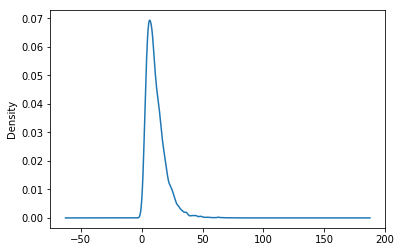

In [35]:
#caculate the duration for each trip

trip_duration= full_tripdata.iloc[:,0:7] 
trip_duration[" pickup_datetime_x"] = pd.to_datetime(trip_duration[" pickup_datetime_x"])
trip_duration[" dropoff_datetime"] = pd.to_datetime(trip_duration[" dropoff_datetime"])

trip_duration["duration"] = (trip_duration[' dropoff_datetime']- trip_duration[' pickup_datetime_x']).astype('timedelta64[m]') + 0.001
#trip_duration["duration"] = trip_duration.apply(lambda x: if not np.isnan(x['mangoes price']) else x['diff'], axis=1)

#trip_duration["duration"].plot.hist(bins=50)
trip_duration["duration"].plot.kde()

trip_duration["duration"].describe()
#trip_duration["STD"] = pd.rolling_std(trip_duration["duration"])

#trip_duration.head()

count    24974.000000
mean         2.214166
std          0.875056
min         -6.907755
25%          1.791926
50%          2.302685
75%          2.708117
max          4.828322
Name: logduration, dtype: float64

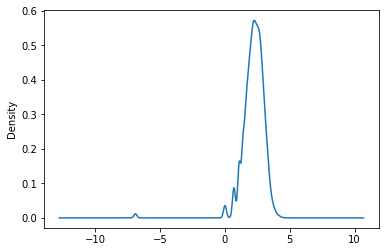

In [41]:
#the above caculated trip duration are not exactly followoing the normal distribution,
#so, I applyed the natural logarithm to transfrom the data to normal distribution 
# https://datascience.stackexchange.com/questions/14216/transform-a-skewed-distribution-into-a-gaussian-distribution


#import until
import numpy as np

trip_duration["logduration"] = np.log(trip_duration['duration'])

#trip_duration["logduration"].plot.hist(bins=50)
trip_duration["logduration"].plot.kde()


trip_duration["logduration"].describe()

In [51]:
# the highest stardard deviation trip are those data away from the mean by 3 STD
# http://libweb.surrey.ac.uk/library/skills/Number%20Skills%20Leicester/page_17.htm
trip_duration["logduration"].describe()
mean = trip_duration["logduration"].mean()
std = trip_duration["logduration"].std()

lowerbound = mean - 3 * std
upperbound = mean + 3 * std

#print lowerbound,upperbound

trip_duration.describe()

out3STDTrips = trip_duration.copy()
out3STDTrips = out3STDTrips.loc[(out3STDTrips['logduration'] < lowerbound) | (out3STDTrips['logduration'] > upperbound)]

print out3STDTrips.head()
out3STDTrips.describe()


                             medallion                      hack_license  \
62    69D959302A72045B426E936BB0BB2723  5EE1CD0A797F45CA403AD5D4AB224ED1   
748   1431E056A35F588107E3BC378BB6B350  1BF3CE47ECE4C2B61C36990EDAEE7CC2   
749   1431E056A35F588107E3BC378BB6B350  1BF3CE47ECE4C2B61C36990EDAEE7CC2   
2622  CDC40A1F194AA8D4CA9EF331A266E1FA  266352E176E098D2E05B75758896E874   
2714  9B375E774BDAA8CC45CE6F3BF072C1E2  5D4D3F068DD946BBA080CCE7F72D34DA   

      vendor_id   rate_code  store_and_fwd_flag   pickup_datetime_x  \
62          CMT           1                   N 2013-04-05 06:21:22   
748         VTS           5                 NaN 2013-04-12 20:16:00   
749         VTS           5                 NaN 2013-04-12 20:16:00   
2622        VTS           1                 NaN 2013-04-12 23:31:00   
2714        VTS           1                 NaN 2013-04-12 21:29:00   

        dropoff_datetime  duration  logduration  
62   2013-04-05 06:21:23     0.001    -6.907755  
748  2013-04-12 

,rate_code,duration,logduration
count,86.000000,8.600000e+01,8.600000e+01
mean,2.790698,1.000000e-03,-6.907755e+00
std,1.947042,6.543367e-19,1.518759e-14
min,1.000000,1.000000e-03,-6.907755e+00
25%,1.000000,1.000000e-03,-6.907755e+00
50%,1.500000,1.000000e-03,-6.907755e+00
75%,5.000000,1.000000e-03,-6.907755e+00
max,5.000000,1.000000e-03,-6.907755e+00


In [14]:
import geojsonio
geojsonio.display(locs_in_NYC.head(1))

u'http://geojson.io/#data=data:application/json,%7B%22type%22%3A%20%22FeatureCollection%22%2C%20%22features%22%3A%20%5B%7B%22geometry%22%3A%20%7B%22type%22%3A%20%22FeatureCollection%22%2C%20%22features%22%3A%20%5B%7B%22geometry%22%3A%20%7B%22type%22%3A%20%22Point%22%2C%20%22coordinates%22%3A%20%5B-73.97811899999999%2C%2040.763451%5D%7D%2C%20%22type%22%3A%20%22Feature%22%2C%20%22id%22%3A%20%223%22%2C%20%22bbox%22%3A%20%5B-73.97811899999999%2C%2040.763451%2C%20-73.97811899999999%2C%2040.763451%5D%2C%20%22properties%22%3A%20%7B%22index_right%22%3A%201984%2C%20%22Shape__Length%22%3A%200.00860540470068698%2C%20%22OBJECTID%22%3A%201985%2C%20%22ZONEDIST%22%3A%20%22C6-6%22%2C%20%22longtitude%22%3A%20-73.97811899999999%2C%20%22Shape__Area%22%3A%204.10842657307098e-06%2C%20%22latitude%22%3A%2040.763451%7D%7D%5D%2C%20%22bbox%22%3A%20%5B-73.97811899999999%2C%2040.763451%2C%20-73.97811899999999%2C%2040.763451%5D%7D%2C%20%22type%22%3A%20%22Feature%22%7D%5D%7D'

In [15]:
pickupLocations = full_tripdata.iloc[]

SyntaxError: invalid syntax (<ipython-input-15-5e00db64f69e>, line 1)

In [ ]:
from scipy.stats import norm
print norm.cdf(numberofpassanagers,mean,std)

In [ ]:
numberofpassanagers.plot.density()

In [ ]:
payment_types = fares.iloc[:,4]

payment_types.hist()

In [ ]:
payment_types.sum()

In [ ]:
print payment_types